<a href="https://colab.research.google.com/github/khyejin1231/Masters-Thesis/blob/main/Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 14.1 MB/s 


In [7]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [10]:
#Let's first load the data
from google.colab import drive
import os
import pandas as pd
#drive.mount('/content/drive', force_remount = True)
#PATH = '/content/drive/My Drive/Colab Notebooks/BDS_Thesis'

#!pip install pickle5
#import pickle5 as pickle

#infile = open(PATH+'/final_labels_no_artists_lemma_10.pkl','rb')
#df = pickle.load(infile)


#url = 'https://github.com/khyejin1231/Masters-Thesis/blob/main/final_labels_no_artists_lemma_10.pkl?raw=true'

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/BDS_Thesis/joined_selected_BERT_xartist_lemma10.csv')
df = df.iloc[:,1:]
#df.reset_index(drop=True, inplace=True)
#df = df.drop_duplicates(keep='first')

Mounted at /content/drive


In [87]:
embeddings = df.iloc[:, 0:767]
y = df.iloc[:,-1]

In [88]:
#Define train and test set.
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch
import numpy as np

embeddings = np.array(embeddings)
y = np.array(y)

train_features, test_features, train_labels, test_labels = train_test_split(embeddings, y, stratify=y, test_size=0.2)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, stratify=train_labels, test_size=0.2)


# Combine the training inputs into a TensorDataset.


In [13]:
#GPU connection
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [39]:
'''
#Simple model

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner
#Model building
def model(hp):
  with tf.device('/device:GPU:0'):
    model = keras.Sequential()
    model.add(keras.layers.Flatten())

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
    hp_units1 = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units1, activation='relu'))
    model.add(layers.Dense(units=hp_units2, activation='relu'))
    model.add(layers.Dense(1, activation="softmax"))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

model(keras_tuner.HyperParameters())

In [102]:
#Advanced model
#We should shuffle the data each epoch
class MyHyperModel(keras_tuner.HyperModel):
  def build(self, hp):
    with tf.device('/device:GPU:0'):
      model = keras.Sequential()
      model.add(layers.Flatten())
      # Tune the number of layers.
      for i in range(hp.Int("num_layers", 1, 10)):
          model.add(
              layers.Dense(
                  # Tune number of units separately.
                  units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                  activation=hp.Choice("activation", ["relu", "tanh"]),
              )
          )
      if hp.Boolean("dropout"):
          model.add(layers.Dropout(rate=0.25))
      
      model.add(layers.Dense(1, activation="sigmoid"))
      
      learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
      model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
          loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
          metrics=[tf.keras.metrics.BinaryAccuracy()])
      return model

  def fit(self, hp, model, x, y, validation_data = None, **kwargs):
        
        #We try normalization here
        if hp.Boolean("normalize"):
          x = layers.Normalization()(x)
        if validation_data:
          x_val, y_val = validation_data
          validation_data = (x_val, y_val)
        
        return model.fit(
            x, y,
            # Tune whether to shuffle the data in each epoch.
            shuffle=hp.Boolean("shuffle"),
            validation_data = validation_data,
            **kwargs,
        )


tuner = kt.Hyperband(MyHyperModel(),
                     objective='val_binary_accuracy',
                     max_epochs=20,
                     overwrite=True,
                     factor=3,
                     directory='/content/drive/My Drive/Colab Notebooks/BDS_Thesis',
                     project_name='keras')

tuner.search(train_features, train_labels, epochs=10, validation_data=(val_features, val_labels))

Trial 5 Complete [00h 00m 14s]
val_binary_accuracy: 0.5861714482307434

Best val_binary_accuracy So Far: 0.6338285803794861
Total elapsed time: 00h 01m 19s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
9                 |4                 |num_layers
416               |192               |units_0
tanh              |tanh              |activation
True              |False             |dropout
0.0043869         |0.00037477        |lr
480               |32                |units_1
64                |32                |units_2
224               |32                |units_3
True              |False             |normalize
True              |False             |shuffle
416               |None              |units_4
448               |None              |units_5
160               |None              |units_6
448               |None              |units_7
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2       

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 111, in _build_wrapper
    return self._build(hp, *args, **kwargs)
  File "<ipython-input-102-3250347c993f>", line 18, in build
    drop = hp.Choice("drop", [0.1,0.2,0.3,0.4], parent_name = "dropout")
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 787, in Choice
    with self._maybe_conditional_scope(parent_name, parent_values):
  File "/usr/lib/python3.7/contextlib.py", line 112, in __enter__
    return next(self.gen)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 1077, in _maybe_conditional_scop

Invalid model 0/5
Invalid model 1/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 111, in _build_wrapper
    return self._build(hp, *args, **kwargs)
  File "<ipython-input-102-3250347c993f>", line 18, in build
    drop = hp.Choice("drop", [0.1,0.2,0.3,0.4], parent_name = "dropout")
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 787, in Choice
    with self._maybe_conditional_scope(parent_name, parent_values):
  File "/usr/lib/python3.7/contextlib.py", line 112, in __enter__
    return next(self.gen)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 1077, in _maybe_conditional_scop

Invalid model 2/5
Invalid model 3/5
Invalid model 4/5
Invalid model 5/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hypermodel.py", line 111, in _build_wrapper
    return self._build(hp, *args, **kwargs)
  File "<ipython-input-102-3250347c993f>", line 18, in build
    drop = hp.Choice("drop", [0.1,0.2,0.3,0.4], parent_name = "dropout")
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 787, in Choice
    with self._maybe_conditional_scope(parent_name, parent_values):
  File "/usr/lib/python3.7/contextlib.py", line 112, in __enter__
    return next(self.gen)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/hyperparameters.py", line 1077, in _maybe_conditional_scop

RuntimeError: ignored

In [92]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5)

In [93]:
tuner.search(train_features, train_labels, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 42 Complete [00h 00m 44s]
val_binary_accuracy: 0.6455714106559753

Best val_binary_accuracy So Far: 0.6562857031822205
Total elapsed time: 00h 23m 03s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [95]:
tuner.search_space_summary()

Search space summary
Default search space size: 16
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
normalize (Boolean)
{'default': False, 'conditions': []}
shuffle (Boolean)
{'default': False, 'conditions': []}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32,

In [79]:
#Train the model
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_features, train_labels, epochs=50, validation_split=0.2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1094/1094 [==============================] - 5s 4ms/step - loss: 0.6637 - binary_accuracy: 0.6087 - val_loss: 0.6554 - val_binary_accuracy: 0.6306
Epoch 2/50
1094/1094 [==============================] - 5s 4ms/step - loss: 0.6522 - binary_accuracy: 0.6276 - val_loss: 0.6440 - val_binary_accuracy: 0.6414
Epoch 3/50
1094/1094 [==============================] - 4s 4ms/step - loss: 0.6450 - binary_accuracy: 0.6322 - val_loss: 0.6437 - val_binary_accuracy: 0.6381
Epoch 4/50
1094/1094 [==============================] - 4s 4ms/step - loss: 0.6381 - binary_accuracy: 0.6391 - val_loss: 0.6358 - val_binary_accuracy: 0.6427
Epoch 5/50
1094/1094 [==============================] - 4s 4ms/step - loss: 0.6314 - binary_accuracy: 0.6448 - val_loss: 0.6342 - val_binary_accuracy: 0.6439
Epoch 6/50
1094/1094 [==============================] - 4s 4ms/step - loss: 0.6239 - binary_accuracy: 0.6514 - val_loss: 0.6298 - val_binary_accuracy: 0.6433
Epoch 7/50
1094/1094 [==============================] - 4s 4ms/

In [96]:
val_acc_per_epoch = history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 8


In [97]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_features, train_labels, epochs=best_epoch, validation_split=0.2)

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


875/875 [==============================] - 3s 3ms/step - loss: 0.6653 - binary_accuracy: 0.6064 - val_loss: 0.6529 - val_binary_accuracy: 0.6287
Epoch 2/8
875/875 [==============================] - 2s 3ms/step - loss: 0.6525 - binary_accuracy: 0.6257 - val_loss: 0.6455 - val_binary_accuracy: 0.6333
Epoch 3/8
875/875 [==============================] - 3s 3ms/step - loss: 0.6438 - binary_accuracy: 0.6337 - val_loss: 0.6612 - val_binary_accuracy: 0.6014
Epoch 4/8
875/875 [==============================] - 3s 3ms/step - loss: 0.6377 - binary_accuracy: 0.6379 - val_loss: 0.6392 - val_binary_accuracy: 0.6416
Epoch 5/8
875/875 [==============================] - 3s 3ms/step - loss: 0.6300 - binary_accuracy: 0.6479 - val_loss: 0.6327 - val_binary_accuracy: 0.6471
Epoch 6/8
875/875 [==============================] - 3s 3ms/step - loss: 0.6246 - binary_accuracy: 0.6533 - val_loss: 0.6319 - val_binary_accuracy: 0.6457
Epoch 7/8
875/875 [==============================] - 3s 3ms/step - loss: 0.6186 

In [98]:
eval_result = hypermodel.evaluate(test_features, test_labels)
print("[test loss, test accuracy]:", eval_result)

342/342 [==============================] - 1s 2ms/step - loss: 0.6385 - binary_accuracy: 0.6393
[test loss, test accuracy]: [0.6385493278503418, 0.6392977833747864]


In [134]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

pred_labels = hypermodel.predict(test_features) > 0.5
print(confusion_matrix(test_labels, pred_labels))


[[5401 1011]
 [2934 1591]]


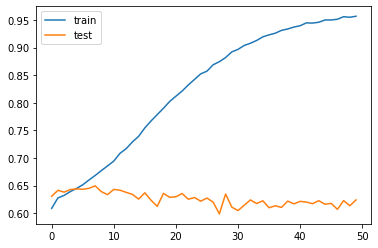

In [135]:
from matplotlib import pyplot

pyplot.plot(history.history['binary_accuracy'], label='train')
pyplot.plot(history.history['val_binary_accuracy'], label='test')
pyplot.legend()
pyplot.show()